# ArchiveTeam Ingest Rate

This notebook shows how to chart the growth of the ArchiveTeam collection at the Internet Archive. It relies on the [Internet Archive's Scrape API](https://archive.org/help/aboutsearch.htm) to iterate through all the items in a collections. You should be able to search and replace *archiveteam* with another Internet Archive collection you are interested in if you want.

Once we have summarized the item metadata for the ArchiveTeam's collection we'll create some simple charts to visualize the growth over time.

## Get Item Metadata

Let's get the most complicated bit out of the way first. We need a function to return all the item metadata for a collection from the API. In addition to the required *collection_id* this function will also allow an optional *count* parameter (to arbitrarily limit the number of results), and an optional *progress* bar for long running data collection.

The *get_items* function returns an interator which we will use in a moment.

In [1]:
import tqdm
import requests

def get_items(collection_id, count=None, progress=False):        
    url = "https://archive.org/services/search/v1/scrape"
    params = {
        "q": "collection:" + collection_id,
        "fields": "collection,item_size,addeddate,identifier",
        "sorts": "addeddate desc",
        "rows": 1000
    }
    
    items_seen = 0
    cursor = None
    stop = False
    
    # set up a progress bar for feedback when collecting a lot of data
    if progress and not count:
        results = requests.get(url, params=params).json()
        progress_bar = tqdm.tqdm(total=results['total'], unit='item')
    elif progress:
        progress_bar = tqdm.tqdm(total=count, unit='item')
    else:
        progress_bar = None
    
    while not stop:
        results = requests.get(url, params=params).json()
        if results['count'] == 0:
            stop = True
        else:
            for item in results['items']:
                items_seen += 1
                if progress_bar:
                    progress_bar.update(1)
                if count and items_seen > count:
                    stop = True
                    break
                yield item
            
            if 'cursor' not in results:
                stop = True
            else:
                params['cursor'] = results['cursor']            

    if progress_bar:
        progress_bar.close()

Let's try out the function to get 10 results:

In [2]:
for item in get_items('archiveteam', count=10):
    print(item)

{'identifier': 'chromebot-2019-01-02-c6334f', 'addeddate': '2019-01-02T19:21:22Z', 'collection': ['archiveteam_chromebot', 'archiveteam'], 'item_size': 95295847}
{'identifier': 'archiveteam_archivebot_go_20190102180002', 'addeddate': '2019-01-02T18:17:48Z', 'collection': ['archivebot', 'archiveteam'], 'item_size': 48535883274}
{'identifier': 'archiveteam_newssites_20190102170029', 'addeddate': '2019-01-02T18:00:12Z', 'collection': ['archiveteam_newssites', 'archiveteam'], 'item_size': 55466926841}
{'identifier': 'archiveteam_newssites_20190102155155', 'addeddate': '2019-01-02T16:59:36Z', 'collection': ['archiveteam_newssites', 'archiveteam'], 'item_size': 55418539339}
{'identifier': 'youtube-H6B7HmoeGGM', 'addeddate': '2019-01-02T16:58:36Z', 'collection': ['archiveteam_youtube', 'archiveteam'], 'item_size': 306371916}
{'identifier': 'youtube-3UIRB6H7Gh8', 'addeddate': '2019-01-02T16:42:24Z', 'collection': ['archiveteam_youtube', 'archiveteam'], 'item_size': 40638932}
{'identifier': 'yo

Looks good! Now we can move on to working with the item metadata.

## Summarize

Next we need a function that will walk over the set of items and summarize some things like the sizes by day, and sizes by collection. The results are returned as Counter objects.

In [3]:
from collections import Counter

def summarize(items):
    bytes_per_day = Counter()
    bytes_per_collection = Counter()
    
    for item in items:
        date = item.get('addeddate', '').split('T')[0]
        if date:
            bytes_per_day[date] += item['item_size']
        for coll_id in item['collection']:
            bytes_per_collection[coll_id] += item['item_size']
            
    return {
        "bytes_per_day": bytes_per_day,
        "bytes_per_collection": bytes_per_collection
    }

Let's try this out on 10,000 of the most recent items uploaded.

In [4]:
summary = summarize(get_items('archiveteam', count=10000))

Now we can print the three highest upload days for those items:

In [5]:
from pprint import pprint

pprint(summary['bytes_per_day'].most_common(3))

[('2018-12-12', 6136367854556),
 ('2018-12-11', 5653343238291),
 ('2018-12-17', 5605217081034)]


Or the top fivee collections by size for those items:

In [6]:
pprint(summary['bytes_per_collection'].most_common(5))

[('archiveteam', 82220767031003),
 ('archiveteam_tumblr', 46294872028478),
 ('archivebot', 29007696205866),
 ('archiveteam_newssites', 4001579842223),
 ('archiveteam_youtube', 2011535245638)]


## Collect

Now we're ready to run through all the results. It's going to take a while for ArchiveTeam since they have about half a million items. So notice that we turn on the progress bar so you can see that something is happening. Also, let's only do this full summariation when we don't already have the CSV files that we're going to save the data in.

Are you ready? Let's go!

In [7]:
from csv import DictWriter

if True or not os.path.isfile('ArchiveTeam-sizes.csv'):
    
    summary = summarize(get_items('archiveteam', progress=True))
          
    with open('ArchiveTeam-collections.csv', 'w') as output:
        writer = DictWriter(output, fieldnames=['collection', 'size'])
        writer.writeheader()
        for collection, size in summary['bytes_per_collection'].items():
            writer.writerow({"collection": collection, "size": size})
            
    with open('ArchiveTeam-dates.csv', 'w') as output:
        writer = DictWriter(output, fieldnames=['date', 'size'])
        writer.writeheader()
        # note: we sort the csv by date
        for date, size in sorted(summary['bytes_per_day'].items()):
            writer.writerow({"date": date, "size": size})

100%|██████████| 494892/494892 [38:42<00:00, 213.10item/s]   


## Analyze

So now we have our summary data in CSV files, so we can (finally) analyze it a bit with [pandas](https://pandas.pydata.org/) and maybe generate a useful graph or two.

First we'll import pandas and load in the dates summary data as a pandas DataFrame.

In [8]:
import pandas as pd

sizes = pd.read_csv('ArchiveTeam-dates.csv', index_col=0, parse_dates=True)
sizes.head()

,size
date,
2009-03-10,214577441
2009-03-12,214577249
2010-11-30,75503895
2011-03-21,3068211032
2011-04-04,1952767638


So now we've got a DataFrame that is indexed by the day, with one Series *size* that contains the bytes. I don't know about you, but I find it difficult to think of size in terms of bytes. So let's use pandas to calcuate a gigabyte column for us using the bytes:

In [9]:
sizes = sizes.assign(gb=lambda x: x / 1024 ** 3)
sizes.head()

,size,gb
date,,
2009-03-10,214577441,0.199841
2009-03-12,214577249,0.199841
2010-11-30,75503895,0.070318
2011-03-21,3068211032,2.857494
2011-04-04,1952767638,1.818657


Now we can tell pandas to calcuate some statistics on our data:

In [10]:
sizes.describe()

,size,gb
count,2.471000e+03,2471.000000
mean,1.436465e+12,1337.812356
std,1.697580e+12,1580.994753
min,2.566200e+04,0.000024
25%,3.103716e+11,289.056089
50%,9.391496e+11,874.651194
75%,1.869646e+12,1741.243686
max,1.311028e+13,12209.895500


## Visualize the Data

Since we have thousands of days, it might be useful to see the stats by month rather than by day. That's not too hard to do since our dataframe as a date index and pandas support for [timeseries](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries) data allows us to resample the dataframe on a monthly basis:

In [82]:
sizes_by_month = sizes.resample('M').sum()
sizes_by_month.tail()

,size,gb
date,,
2018-09-30,32222980445224,30009.989110
2018-10-31,43683078026730,40683.036695
2018-11-30,47831549118548,44546.601473
2018-12-31,75050804302576,69896.508290
2019-01-31,5391361008158,5021.096215


Now let's create a plot of the gigabytes per month:

Text(0, 0.5, 'Gigabytes per Month')

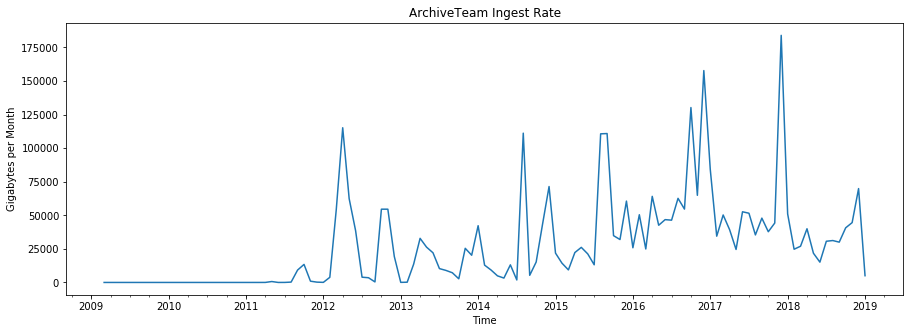

In [83]:
%matplotlib inline

plot = sizes_by_month['gb'].plot(figsize=(15, 5), title="ArchiveTeam Ingest Rate")

plot.set_xlabel('Time')
plot.set_ylabel('Gigabytes per Month')


We can also take a look at the collections. For example lets look at the top 25 collections by size. But remember, a given item can be in more than one collection. First we need to load in our data again, calculate that gigabyte value again, and sortby it:

In [64]:
colls = pd.read_csv('ArchiveTeam-collections.csv', index_col=0, parse_dates=True)
colls = colls.assign(gb=lambda x: x / 1024 ** 3)
colls = colls.sort_values(by='gb', ascending=False)

Next we can drop the *archiveteam* collection as well as any collections starting with *fav-* since these are users who have favorited items in the collection, and not directly related to the uploading of content:

In [73]:
top = colls.drop('archiveteam').drop('web')
favs = filter(lambda i: i.startswith('fav-'), top.index)
top.drop(labels=favs, inplace=True)

And now we can get the top 25 collections by size, and lump the rest into a category of *Other* and display them as a pie chart:

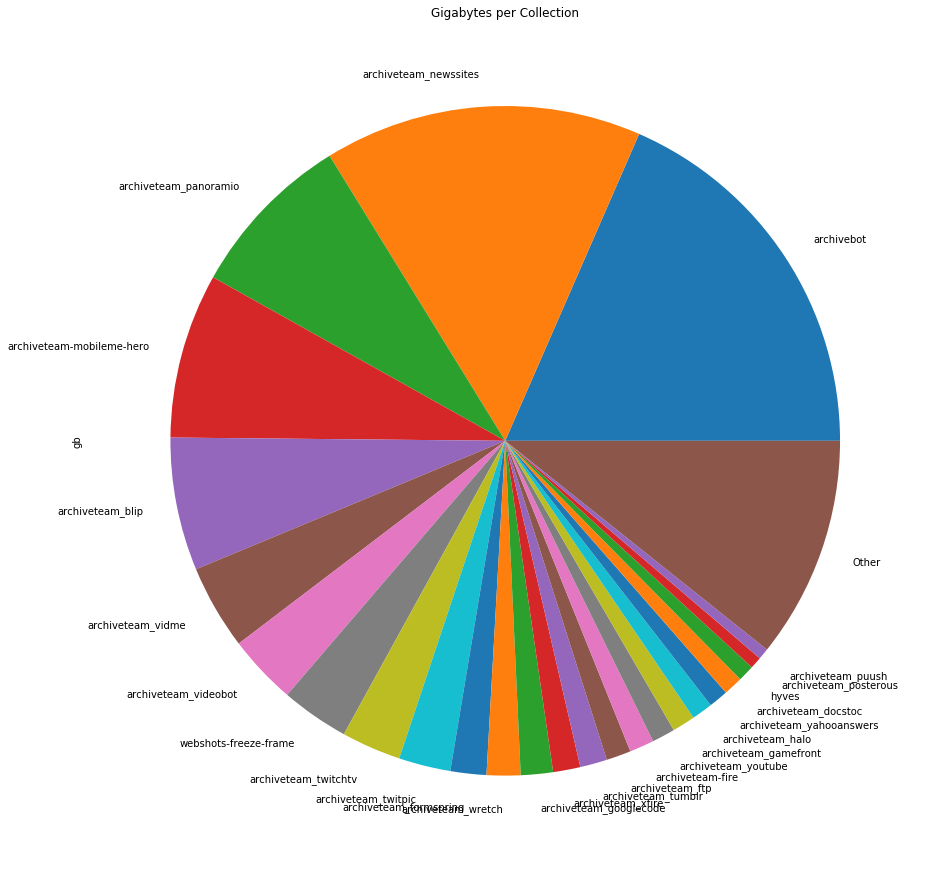

In [74]:
rest = top[25:]
top = top.head(25)

other = pd.DataFrame({'size': rest['size'].sum(), 'gb': rest['gb'].sum()}, index=['Other'])
top = top.append(other)

plot = top.plot.pie('gb', figsize=(15, 20), legend=False, title="Gigabytes per Collection")